# Wrangle and Analyze Data

I will be wrangling the tweet archive dataset of Twitter user `@dog_rates`, also known as `WeRateDogs`. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

**This data was extracted programmatically.**

* The ratings probably aren't all correct. 
* Same goes for the dog names and probably dog stages (see below for more information on these) too. 
* These columns need to assessed and cleaned to use them for analysis and visualization.
* `retweet` count and `favorite` count are two of the notable column omissions.
* We have the tweet IDs from WeRateDogs Twitter archive can gather the data for all 5000+ tweets.

**Image Predictions File**

Every image in the `WeRateDogs Twitter` archive was ran through a neural network that can classify breeds of dogs. 
We have the top three only class prediction alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).
* `tweet_id` is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
* `p1` is the algorithm's #1 prediction for the image in the tweet → **golden retriever**
* `p1_conf` is how confident the algorithm is in its #1 prediction → **95%**
* `p1_dog` is whether or not the #1 prediction is a breed of dog → **TRUE**
* `p2` is the algorithm's second most likely prediction → **Labrador retriever**
* `p2_conf` is how confident the algorithm is in its #2 prediction → **1%**
* `p2_dog` is whether or not the #2 prediction is a breed of dog → **TRUE**
* etc.

## Key Points

Key points to keep in mind when data wrangling for this project:

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, **the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset**.
* Cleaning includes merging individual pieces of data according to the rules of tidy data.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

## Projects Details

1. Data wrangling, which consists of:
    * Gathering data
    * Assessing data
    * Cleaning data
2. Storing, analyzing, and visualizing your wrangled data
3. Reporting on 
    * your data wrangling efforts 
    * your data analyses and visualizations

# Data Wrangling

## #1. Gathering Data

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import tweepy
import json
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg' 

%matplotlib inline

### 1. The WeRateDogs Twitter archive

Download this file manually, this file was given to me: `twitter_archive_enhanced.csv`

The dataset:

One column the archive does contain though: 

* each tweet's text,  used to extract rating; 
* dog name; 
* dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." 
* tweets with ratings only (there are 2356).

In [51]:
# load the data
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')
# view the first 5 rows of the dataframe
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### #2 The tweet image predictions

This file `image_predictions.tsv` is hosted on Udacity's servers and should be downloaded programmatically using the `Requests` library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [4]:
# use the URL to get the file from the servers 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# send a GET request to the url 
response = requests.get(url)
# the url attribute of the response object
response.url

'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [5]:
# save tsv to file
with open("image-predictions.tsv", mode="wb") as file:
    file.write(response.content)

In [3]:
# open to file to see if everything is working
image_predictions_df = pd.read_csv("image-predictions.tsv", sep='\t')
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### #3 Tweets Data

In this project, I'll be using Tweepy to query Twitter's API for additional data beyond the data included in the WeRateDogs Twitter archive. 

This additional data will include: 
* *retweet count* 
* *favorite count* (*like*)

Using the `tweet ID` in the *WeRateDogs Twitter archive*:
* Query the Twitter API for each tweet's JSON data using Python's [Tweepy](http://www.tweepy.org/) library
* Store each tweet's entire set of JSON data in a file called tweet_json.txt file. 
* Each tweet's JSON data should be written to its own line. 
* Then read this `.txt` file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

Tweet data is stored in JSON format by Twitter. Getting tweet JSON data via tweet ID using Tweepy is described well in this [StackOverflow answer](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id).

*Note that setting the `tweet_mode` parameter to `'extended'` in the `get_status` call, i.e., `api.get_status(tweet_id, tweet_mode='extended')`, can be useful.

#### Twitter's Rate Limit

Twitter's API has a rate limit. Rate limiting is used to control the rate of traffic sent or received by a server. As per [Twitter's rate limiting info page](https://developer.twitter.com/en/docs/basics/rate-limiting):
>Rate limits are divided into 15 minute intervals

* To query all of the tweet IDs in the WeRateDogs Twitter archive, 20-30 minutes of running time can be expected. 
* Printing out each tweet ID after it was queried and [using a code timer](https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python) were both helpful for sanity reasons. 
* Setting the `wait_on_rate_limit` and `wait_on_rate_limit_notify` parameters to `True` in the `tweepy.api` [class](http://docs.tweepy.org/en/v3.2.0/api.html#API) is useful as well.

#### Writing and Reading Twitter JSON

After querying each tweet ID, you will write its JSON data to the required `tweet_json.txt` file with each tweet's JSON data on its own line. You will then read this file, line by line, to create a pandas DataFrame that you will soon assess and clean. 

*This [Reading and Writing JSON to a File in Python article from Stack Abuse, will be useful](http://stackabuse.com/reading-and-writing-json-to-a-file-in-python/).

In [22]:
# create an API object to gather Twitter data.
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

##### #1 Test on a Tweet 

In [33]:
with open('tweet_json_test.txt', 'w') as outfile:
    tweet = api.get_status(666020888022790149, tweet_mode='extended')
    print("Success")
    json.dump(tweet._json, outfile)
    outfile.write('\n')

Success


The entire JSON object is in the `tweet` variable. 

#### #2 Get the tweet ids from the `twitter_archive_df` Data Frame

In [27]:
# get the tweet IDs values
tweet_ids = twitter_archive_df.tweet_id.values
len(tweet_ids)

2356

##### # 3 Query the Twitter's API for JSON data for each tweet ID

In [36]:
# counter
count = 0
# empty dictionary for failled tweet data 
fails_dict = {}
# time the process
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Fail
1790: 677547928504967168
Fail
1791: 677530072887205888
Fail
1792: 677335745548390400
Fail
1793: 677334615166730240
Fail
1794: 677331501395156992
Fail
1795: 677328882937298944
Fail
1796: 677314812125323265
Fail
1797: 677301033169788928
Fail
1798: 677269281705472000
Fail
1799: 677228873407442944
Fail
1800: 677187300187611136
Fail
1801: 676975532580409345
Fail
1802: 676957860086095872
Fail
1803: 676949632774234114
Fail
1804: 676948236477857792
Fail
1805: 676946864479084545
Fail
1806: 676942428000112642
Fail
1807: 676936541936185344
Fail
1808: 676916996760600576
Fail
1809: 676897532954456065
Fail
1810: 676864501615042560
Fail
1811: 676821958043033607
Fail
1812: 676819651066732545
Fail
1813: 676811746707918848
Fail
1814: 676776431406465024
Fail
1815: 676617503762681856
Fail
1816: 676613908052996102
Fail
1817: 676606785097199616
Fail
1818: 676603393314578432
Fail
1819: 676593408224403456
Fail
1820: 676590572941893632
Fail
1821: 676588346097852417
Fail
1822: 676582956622721024
Fail
1823:

Fail
2064: 671159727754231808
Fail
2065: 671154572044468225
Fail
2066: 671151324042559489
Fail
2067: 671147085991960577
Fail
2068: 671141549288370177
Fail
2069: 671138694582165504
Fail
2070: 671134062904504320
Fail
2071: 671122204919246848
Fail
2072: 671115716440031232
Fail
2073: 671109016219725825
Fail
2074: 670995969505435648
Fail
2075: 670842764863651840
Fail
2076: 670840546554966016
Fail
2077: 670838202509447168
Fail
2078: 670833812859932673
Fail
2079: 670832455012716544
Fail
2080: 670826280409919488
Fail
2081: 670823764196741120
Fail
2082: 670822709593571328
Fail
2083: 670815497391357952
Fail
2084: 670811965569282048
Fail
2085: 670807719151067136
Fail
2086: 670804601705242624
Fail
2087: 670803562457407488
Fail
2088: 670797304698376195
Fail
2089: 670792680469889025
Fail
2090: 670789397210615808
Fail
2091: 670786190031921152
Fail
2092: 670783437142401025
Fail
2093: 670782429121134593
Fail
2094: 670780561024270336
Fail
2095: 670778058496974848
Fail
2096: 670764103623966721
Fail
2097:

Fail
2338: 666268910803644416
Fail
2339: 666104133288665088
Fail
2340: 666102155909144576
Fail
2341: 666099513787052032
Fail
2342: 666094000022159362
Fail
2343: 666082916733198337
Fail
2344: 666073100786774016
Fail
2345: 666071193221509120
Fail
2346: 666063827256086533
Fail
2347: 666058600524156928
Fail
2348: 666057090499244032
Fail
2349: 666055525042405380
Fail
2350: 666051853826850816
Fail
2351: 666050758794694657
Fail
2352: 666049248165822465
Fail
2353: 666044226329800704
Fail
2354: 666033412701032449
Fail
2355: 666029285002620928
Fail
2356: 666020888022790149
Fail
903.3467041844569
{888202515573088257: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 873697596434513921: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 872668790621863937: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 869988702071779329: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 866816280283807744: TweepError

In [11]:
# return failed tweets and crete a txt file with each tweet per line
def tweets(tweet_ids):
    # counter
    count = 0
    # empty dictionary for failled tweet data 
    fails_dict = {}
    # time the process
    start = timer()

    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json2.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)
    return fails_dict

In [38]:
len(fails_dict)

707

We will get the `.response.status_code` attribut for each tweet and make two lists with tweets ids:
* one for the `404` status code with the message: `No status found with that ID.`
* one for the `429` status code with the message: `Rate limit exceeded`

In [133]:
# get the other tweets that have the message Rate limit exceeded
limit_tweet_ids = []
no_found_tweet_ids = []
for key in fails_dict:
    if fails_dict[key].response.status_code == 404:
        no_found_tweet_ids.append(key)
    elif fails_dict[key].response.status_code == 429:
        limit_tweet_ids.append(key)

In [121]:
fails_dict[888202515573088257].response.status_code

404

In [122]:
fails_dict[666020888022790149].response.status_code

429

In [105]:
type(fails_dict[888202515573088257])

tweepy.error.TweepError

In [138]:
# check if the sum of the length of the two lists is equal to the fails dict length
len(no_found_tweet_ids) + len(limit_tweet_ids) == len(fails_dict)

True

In [140]:
# create another txt file, tweet_json2.txt, with the other tweets 
tweets(limit_tweet_ids)

1: 682788441537560576
Success
2: 682750546109968385
Success
3: 682697186228989953
Success
4: 682662431982772225
Success
5: 682638830361513985
Success
6: 682429480204398592
Success
7: 682406705142087680
Success
8: 682393905736888321
Success
9: 682389078323662849
Success
10: 682303737705140231
Success
11: 682259524040966145
Success
12: 682242692827447297
Success
13: 682088079302213632
Success
14: 682059653698686977
Success
15: 682047327939461121
Success
16: 682032003584274432
Success
17: 682003177596559360
Success
18: 681981167097122816
Success
19: 681891461017812993
Success
20: 681694085539872773
Success
21: 681679526984871937
Success
22: 681654059175129088
Success
23: 681610798867845120
Success
24: 681579835668455424
Success
25: 681523177663676416
Success
26: 681340665377193984
Success
27: 681339448655802368
Success
28: 681320187870711809
Success
29: 681302363064414209
Success
30: 681297372102656000
Success
31: 681281657291280384
Success
32: 681261549936340994
Success
33: 6812424184532

Success
261: 674075285688614912
Success
262: 674063288070742018
Success
263: 674053186244734976
Success
264: 674051556661161984
Success
265: 674045139690631169
Success
266: 674042553264685056
Success
267: 674038233588723717
Success
268: 674036086168010753
Success
269: 674024893172875264
Success
270: 674019345211760640
Success
271: 674014384960745472
Success
272: 674008982932058114
Success
273: 673956914389192708
Success
274: 673919437611909120
Success
275: 673906403526995968
Success
276: 673887867907739649
Success
277: 673716320723169284
Success
278: 673715861853720576
Success
279: 673711475735838725
Success
280: 673709992831262724
Success
281: 673708611235921920
Success
282: 673707060090052608
Success
283: 673705679337693185
Success
284: 673700254269775872
Success
285: 673697980713705472
Success
286: 673689733134946305
Success
287: 673688752737402881
Success
288: 673686845050527744
Success
289: 673680198160809984
Success
290: 673662677122719744
Success
291: 673656262056419329
Success


Success
518: 668994913074286592
Success
519: 668992363537309700
Success
520: 668989615043424256
Success
521: 668988183816871936
Success
522: 668986018524233728
Success
523: 668981893510119424
Success
524: 668979806671884288
Success
525: 668975677807423489
Success
526: 668967877119254528
Success
527: 668960084974809088
Success
528: 668955713004314625
Success
529: 668932921458302977
Success
530: 668902994700836864
Success
531: 668892474547511297
Success
532: 668872652652679168
Success
533: 668852170888998912
Success
534: 668826086256599040
Success
535: 668815180734689280
Success
536: 668779399630725120
Success
537: 668655139528511488
Success
538: 668645506898350081
Success
539: 668643542311546881
Success
540: 668641109086707712
Success
541: 668636665813057536
Success
542: 668633411083464705
Success
543: 668631377374486528
Success
544: 668627278264475648
Success
545: 668625577880875008
Success
546: 668623201287675904
Success
547: 668620235289837568
Success
548: 668614819948453888
Success


{680055455951884288: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}])}

We can see that there is another tweet id, `680055455951884288` with the message of 'No status found with that ID.' Let's add the ID to the `no_found_tweet_ids`

In [144]:
no_found_tweet_ids.append(680055455951884288)

In [145]:
len(no_found_tweet_ids)

16

In [152]:
(len(no_found_tweet_ids) + len(limit_tweet_ids) - 1) == len(fails_dict)

True

In [190]:
len(limit_tweet_ids) 

692

In [192]:
len(tweets)

1649

In [194]:
len(tweets)

691

In [198]:
len(tweets)

2

In [219]:
#tweets

##### #4 Read these .txt files line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite coun

In [4]:
# create an empty list of dictionaries

tweets = []

file_name = ['tweet_json.txt', 'tweet_json2.txt']

# returns a list of tweets from txt file
def txt_to_list(filename):
    with open(filename, 'r') as file:   
        tweets = file.readlines()

    tweets = [x.strip() for x in tweets] 
    
    return tweets

In [5]:
# returns a dataframe
def list_to_df(tweets_list):
    df_list = []
    for tweet in tweets_list:
        tweet_json = json.loads(tweet)
        # tweet id
        tweet_id = tweet_json['id']
        # retweet count
        retweet_count = tweet_json['retweet_count']
        # favorite count
        tweet_favorite_count = tweet_json['favorite_count']
        # Append to list of dictionaries
        df_list.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'tweet_favorite_count': tweet_favorite_count})
        
    # convert list to data frame 
    df_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'tweet_favorite_count'])
        
    return df_tweets

In [6]:
tweets_tweet_json = txt_to_list('tweet_json.txt')
tweets_tweet_json2 = txt_to_list('tweet_json2.txt')

In [7]:
tweet_1 = json.loads(tweets_tweet_json[30])
#tweet_1

In [8]:
df_tweet_json = list_to_df(tweets_tweet_json)
df_tweet_json2 = list_to_df(tweets_tweet_json2)

In [11]:
df_tweet_json.head()

,tweet_id,retweet_count,tweet_favorite_count
0,892420643555336193,8281,37925
1,892177421306343426,6117,32566
2,891815181378084864,4051,24523
3,891689557279858688,8422,41271
4,891327558926688256,9122,39452


In [12]:
df_tweet_json2.head()

,tweet_id,retweet_count,tweet_favorite_count
0,682788441537560576,1188,2580
1,682750546109968385,463,1588
2,682697186228989953,380,1371
3,682662431982772225,1150,3182
4,682638830361513985,644,2149


In [13]:
df_tweet_json.shape[0] + df_tweet_json2.shape[0] 

2340

Now let's create a new database by concatenating these two.

In [9]:
# concatenate two dataframes
tweets_df = pd.concat([df_tweet_json, df_tweet_json2], ignore_index=True)

In [10]:
tweets_df.head()

,tweet_id,retweet_count,tweet_favorite_count
0,892420643555336193,8281,37925
1,892177421306343426,6117,32566
2,891815181378084864,4051,24523
3,891689557279858688,8422,41271
4,891327558926688256,9122,39452


In [16]:
tweets_df.shape

(2340, 3)

Let's save this dataframe to a `csv` file.

In [17]:
tweets_df.to_csv('tweets.csv', index=False)

Let's see if that worked the way we wanted.

In [11]:
tweets_df = pd.read_csv('tweets.csv')
tweets_df.head()

,tweet_id,retweet_count,tweet_favorite_count
0,892420643555336193,8281,37925
1,892177421306343426,6117,32566
2,891815181378084864,4051,24523
3,891689557279858688,8422,41271
4,891327558926688256,9122,39452


In [19]:
tweets_df.shape

(2340, 3)

#### #5 Check the `No status found with that ID` in the given file `tweet-json-copy.txt`

In [12]:
# transform the file to a list
tweets_copy = txt_to_list('tweet-json-copy.txt')
# transform the list to a dataframe
tweets_copy_df = list_to_df(tweets_copy)
# check the head of the dataframe
tweets_copy_df.head()

,tweet_id,retweet_count,tweet_favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [14]:
no_found_tweet_ids = [888202515573088257, 873697596434513921, 872668790621863937, 869988702071779329,
 866816280283807744, 861769973181624320, 845459076796616705, 842892208864923648, 837012587749474308,
 827228250799742977, 812747805718642688, 802247111496568832, 775096608509886464, 770743923962707968,
 754011816964026368, 680055455951884288]

In [24]:
len(no_found_tweet_ids)

16

In [318]:
no_found_tweet_ids 

[888202515573088257,
 873697596434513921,
 872668790621863937,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 845459076796616705,
 842892208864923648,
 837012587749474308,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 775096608509886464,
 770743923962707968,
 754011816964026368,
 680055455951884288]

In [155]:
tweets_copy_df.shape, tweets_df.shape

((2354, 3), (2340, 3))

In [15]:
# these are the tweets we couldn't retrieve from Twitter's API
no_found_tweet_ids_df = tweets_copy_df[tweets_copy_df['tweet_id'].isin(no_found_tweet_ids)]
no_found_tweet_ids_df.shape

(15, 3)

Let's add these id's to the `tweets_df` dataframe to complete the gathering phase

In [16]:
# concatenate two dataframes
tweets_df = pd.concat([tweets_df, no_found_tweet_ids_df], ignore_index=True)

In [17]:
tweets_df.head()

,tweet_id,retweet_count,tweet_favorite_count
0,892420643555336193,8281,37925
1,892177421306343426,6117,32566
2,891815181378084864,4051,24523
3,891689557279858688,8422,41271
4,891327558926688256,9122,39452


In [18]:
# save the new file complete twitter file
tweets_df.to_csv('tweets_complete.csv', index=False)

In [19]:
tweets_df = pd.read_csv('tweets_complete.csv')

In [20]:
# check the shape
tweets_df.shape

(2355, 3)

We actually have one more row than the given file.

In [21]:
tweets_df['tweet_id'].iloc[:5]

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: tweet_id, dtype: int64

In [22]:
tweets_copy_df['tweet_id'].iloc[:5]

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: tweet_id, dtype: int64

## #2. Assessing Data

Detect and document at least:

* eight (8) quality issues  
* two (2) tidiness issues

Notes in Project Motivation:

**Enhanced Twitter Archive You'll need to assess and clean these columns:**

* The ratings probably aren't all correct. 
* Same goes for the dog names and probably dog stages (see below for more information on these) too. 
    * doggo, pupper, puppo, floof(er)
    
* Twitter archives: retweet count and favorite count are two of the notable column omissions. 

### #1 Visually Assess the Data

First, just let's take a look at our data to see if we can spot any issues.

In [26]:
# the twitter archive enhanced
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [27]:
# image predictions table
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:
tweets_df.head()

,tweet_id,retweet_count,tweet_favorite_count
0,892420643555336193,8281,37925
1,892177421306343426,6117,32566
2,891815181378084864,4051,24523
3,891689557279858688,8422,41271
4,891327558926688256,9122,39452


### #2 Programmatic Assessment of the Data 

In [33]:
# number of samples and columns
twitter_archive_df.shape

(2356, 17)

In [34]:
# number of samples and columns
image_predictions_df.shape

(2075, 12)

In [35]:
# number of samples and columns
tweets_df.shape

(2355, 3)

* In the `twitter_archive_df` table there are 2356 observations with 17 columns;
* In the `image_predictions_df` table there are 2075 observations in 12 columns;
* In the `tweets_df` table there are 2354 observations in 3 columns;

We need the same number of observations in all of the tables. `image_predictions_df` table has less observations so we will need to match the `tweet_id` for all of the tables.

In [36]:
# check for duplicates
sum(twitter_archive_df.duplicated()), sum(image_predictions_df.duplicated()), sum(tweets_df.duplicated())

(0, 0, 0)

No duplicates in the datasets.

#### `source` row

We can see that the majority of the data is the same. Let's see how this information can bring value to our analysis.

In [38]:
# check for duplicates in features
sum(twitter_archive_df.source.duplicated())

2352

In [40]:
# let's take a look at the values
twitter_archive_df.source.iloc[1]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

This is a an HTML link that is not related to our analysis. 

In [26]:
# check the datatypes
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [30]:
sum(twitter_archive_df.source.duplicated())

2352

#### Let's take a look at `in_reply_to_status_id` and at `in_reply_to_user_id` columns.

From the [tweepy documentation](http://docs.tweepy.org/en/v3.5.0/api.html) we can see that: 
* `in_reply_to_status_id` – The ID of an existing status that the update is in reply to.

In [51]:
# check the data
twitter_archive_df[~twitter_archive_df.in_reply_to_status_id.isnull()].loc[:,['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id']].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id
30,886267009285017600,8.862664e+17,2.281182e+09
55,881633300179243008,8.816070e+17,4.738443e+07
64,879674319642796034,8.795538e+17,3.105441e+09
113,870726314365509632,8.707262e+17,1.648776e+07
148,863427515083354112,8.634256e+17,7.759620e+07


In [46]:
twitter_archive_df[~twitter_archive_df.in_reply_to_status_id.isnull()].loc[:,['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id']].shape

(78, 3)

It seems like there are 78 entries for `in_reply_to_status_id` and `in_reply_to_user_id`

In [48]:
# take a look at the string equivalent of the first value
str(int(twitter_archive_df[~twitter_archive_df.in_reply_to_status_id.isnull()].in_reply_to_status_id.iloc[0]))

'886266357075128320'

In [74]:
twitter_archive_df[twitter_archive_df['tweet_id'] == 886267009285017600].text

30    @NonWhiteHat @MayhewMayhem omg hello tanner yo...
Name: text, dtype: object

These are replies to a tweet, we need only original tweets.

#### Let's also take a look at `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, there are 181 non-null entries

In [57]:
twitter_archive_df[~twitter_archive_df.retweeted_status_id.isnull()].loc[:,['tweet_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].shape

(181, 4)

In [ ]:
twitter_archive_df[~twitter_archive_df.retweeted_status_id.isnull()].loc[:,['tweet_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].shape

In [58]:
twitter_archive_df[~twitter_archive_df.retweeted_status_id.isnull()].loc[:,['tweet_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].head()

,tweet_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
19,888202515573088257,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000
32,886054160059072513,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000
36,885311592912609280,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000
68,879130579576475649,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000
73,878404777348136964,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000


In [71]:
# take a look at the string equivalent of the first value
str(int(twitter_archive_df[~twitter_archive_df.retweeted_status_id.isnull()].retweeted_status_id.iloc[1]))

'886053734421102592'

In [63]:
str(int(twitter_archive_df[~twitter_archive_df.retweeted_status_user_id.isnull()].retweeted_status_user_id.iloc[0]))

'4196983835'

In [70]:
twitter_archive_df[twitter_archive_df['tweet_id'] == 886054160059072513].text

32    RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...
Name: text, dtype: object

So these are retweets, we need only original tweets. We should delete these rows. Check out the documentation for [retweets](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json.html) 

#### `expanded_urls`

There are only 2297 and we can see that there are cases where there are more photos in the post with more than one link. We should keep just one. The link should look something like: `https://twitter.com/dog_rates/status/` + `tweet_id`

In [78]:
twitter_archive_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [76]:
twitter_archive_df.expanded_urls.iloc[0]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

In [81]:
twitter_archive_df.expanded_urls.iloc[20]

'https://twitter.com/dog_rates/status/888078434458587136/photo/1,https://twitter.com/dog_rates/status/888078434458587136/photo/1'

In [28]:
twitter_archive_df[twitter_archive_df.expanded_urls.isnull()].head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None


We can see that most of the nulls values are retweets and replies. Let's reassess this column after cleanning the other others.

In [90]:
# check the datatypes
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [92]:
# check the datatypes
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id                2340 non-null int64
retweet_count           2340 non-null int64
tweet_favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [93]:
# check for missing values
twitter_archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [94]:
# check for missing values
image_predictions_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [96]:
# non-null unique values
image_predictions_df.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [97]:
# describe the dataset
twitter_archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


We can see that there are some really low rating numerators and denominators. We should check out those ratings.

### Quality

1. `twitter_archive_df` table:
    * Missing data as compared to the image_prediction_clean_df table.
    * Unneeded information in the `source` column 
    * We need only original tweets, no retweets
    * We don’t need tweet replies, only original tweets
    * Inconsistent data values for the expanded_urls column and non-descriptive name
    * Multiple formats for dog names
    * Delete the doggo, floofer, pupper, puppo columns
    * Inaccurate numerators and denominators and missing ratings column
    * Rename tweet_text to text
2. `image_predictions_df` table:
    * There are observations without classification
    * There are three probabilities and classifications 
    * We only need the first probability and the breed name.
    * Non-descriptive column names `p1`, `p1_conf` 
3. `tweets_df` table:
    * More observations than the other two tables

### Tidiness

1. `twitter_archive_df` table
    * Timestamp column contains four variables: year, month, day , hour
    * Dog stages both in column names (doggo, floofer, pupper, puppo) and in the values. These columns should be transformed into one variable: dog_stages with five categories: doggo, floofer, pupper, puppo and None
    * Duplicate url data in the text and in the url column


### We should have two tables:
    
We will have two tables: one for the tweets, with tweets information. The other one for the dogs with specific dogs information. These two tables will share `tweet_id` as the primary key in order to make a relational database.  
    
**tweets**

* tweet_id
* year 
* month 
* day 
* time
* text
* url
* retweet_count
* tweet_favorite_count


**dogs**

* tweet_id
* name
* dog_breed
* dog_stages
* jpg_url
* rating 

## #2. Programmatic Data Cleaning

In [402]:
# create a working copy of the dataframes
twitter_archive_df_clean = twitter_archive_df.copy()
tweets_df_clean = tweets_df.copy()
image_predictions_df_clean = image_predictions_df.copy()

### There are observations in the `image_predictions`  table without classification

#### Define

* Delete observations without classification from the image prediction table.

#### Code

In [403]:
image_predictions_df_clean.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


Let's query the the table to check how many entries with classification.

In [404]:
# entries with classification
image_predictions_df_clean.query('p1_dog != False or p2_dog != False or p3_dog != False').shape

(1751, 12)

We have 1751 entries with classifications. Therefore, 324 images are not classified. Let's delete those entries.

In [405]:
# drop the rows without classification
image_predictions_df_clean.drop(image_predictions_df_clean.query('p1_dog == False and p2_dog == False and p3_dog == False').index, inplace=True)

#### Test

In [406]:
# check if there are any dogs without classification
image_predictions_df_clean.query('p1_dog == False and p2_dog == False and p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [407]:
# chack the dimension of the datafrane
image_predictions_df_clean.shape

(1751, 12)

### `image_predictions`: there are three probabilities and classifications in and also low probability values.

#### Define

* Delete the observations with probabilities less than 0.6 from the image prediction table.

#### Code

In [408]:
# let's take a look at the first three entries
image_predictions_df_clean.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


Check how many probabilities are higher than 0.6.

In [409]:
image_predictions_df_clean.query('p2_conf >= 0.6').shape

(0, 12)

In [410]:
image_predictions_df_clean.query('p3_conf >= 0.6').shape

(0, 12)

In [411]:
image_predictions_df_clean.query('p1_conf >= 0.6 and p1_dog == True').shape

(795, 12)

Only the first probability contains a value higher than 0.6 so we can only fiter for the `p1_conf` and `p1_dog` columns.

In [412]:
# filter the dataframe only for probabilities greater that 0.6 for dogs
image_predictions_df_clean = image_predictions_df_clean.query('p1_conf >= 0.6 and p1_dog == True').reset_index(drop=True)

First probability, `p1_conf` is the greatest but really we want to get better odds of getting the right dog breed than guessing. So, let's query our table in order to get only probabilities higher than 0.6. There are only 795 entries with probabilities higher than 0.6 in guessing the right breed. Let's use only thata data. 

#### Test

In [413]:
# check the dimensions
image_predictions_df_clean.shape

(795, 12)

In [414]:
# check if there are any non-dogs predictions 
image_predictions_df_clean[image_predictions_df_clean.p1_dog != True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


###  `image_predictions_df_clean`: We only need the first probability and the breed name.

#### Define

* Delete the `p1_dog`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog` and `img_num` columns from the `image_predictions_df_clean` table.

#### Code

In [415]:
# delete the columns inplace
image_predictions_df_clean.drop(['p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'img_num'], axis=1, inplace=True)

#### Test

In [416]:
# check the table
image_predictions_df_clean.head()

,tweet_id,jpg_url,p1,p1_conf
0,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137
1,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517
2,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,golden_retriever,0.775930
3,666287406224695296,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,Maltese_dog,0.857531
4,666345417576210432,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,golden_retriever,0.858744


###  `image_predictions_df_clean`: non-descriptive column names `p1`, `p1_conf` 

#### Define

* Rename `p1`, `p1_conf` columns in the `image_predictions_df_clean` table to `dog_breed` and `probability`

#### Code

In [417]:
# rename the columns
image_predictions_df_clean = image_predictions_df_clean.rename(columns={'p1':'dog_breed', 
                                           'p1_conf':'probability'})

#### Test

In [418]:
# assess the head of the table
image_predictions_df_clean.head(1)

,tweet_id,jpg_url,dog_breed,probability
0,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137


In [419]:
# check the column names
list(image_predictions_df_clean)

['tweet_id', 'jpg_url', 'dog_breed', 'probability']

### `dog_breed` values in the `image_predictions_df_clean` table to lowercase

#### Define

* Transform dog breed to lowercase for consistency in the Image Predictions table

#### Code

In [420]:
# lowercase
image_predictions_df_clean.dog_breed = image_predictions_df_clean.dog_breed.str.lower()

#### Test

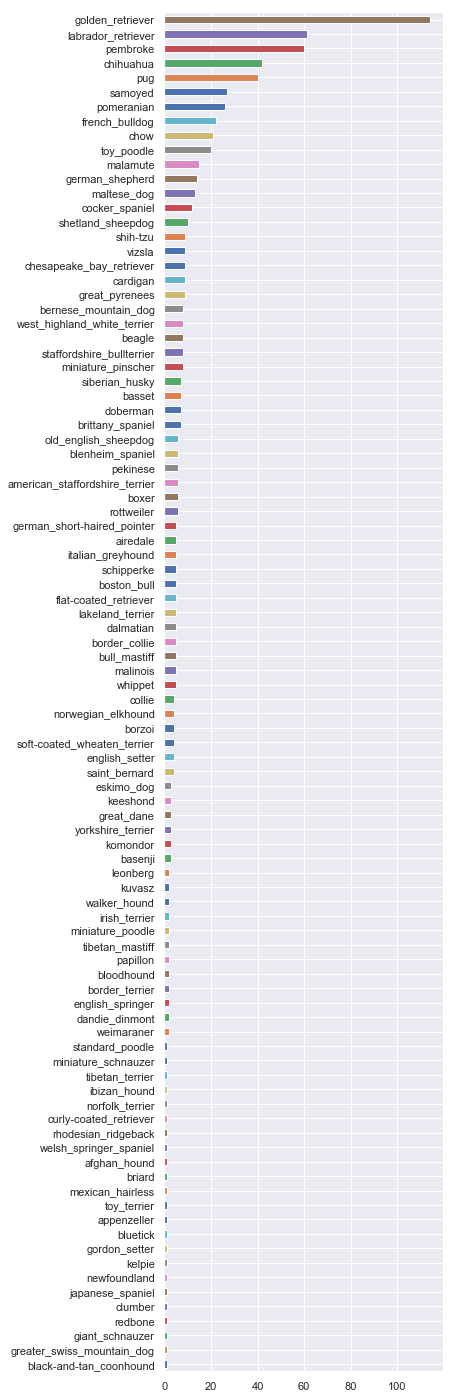

In [421]:
# lets plot an horizontal bar chart of our breeds 
image_predictions_df_clean.dog_breed.value_counts().sort_values().plot(kind='barh', figsize=(5,25));

The majority of our dogs are golden retriever and labrador retriever.

### `tweets_df`, `twitter_archive_df_clean`: more observations than image prediction table.

#### Define

* Match the same number of ids for the three tables.

In [422]:
image_predictions_df_clean.shape, twitter_archive_df_clean.shape

((795, 4), (2356, 17))

In [433]:
tweets_df_clean.shape, twitter_archive_df_clean.shape

((2355, 3), (795, 16))

In [423]:
# tweets in our enhanced data that don't have predictions
twitter_archive_df_clean[~twitter_archive_df_clean['tweet_id'].isin(image_predictions_df_clean['tweet_id'])].shape

(1561, 17)

In [424]:
# drop observations without classification
twitter_archive_df_clean.drop(twitter_archive_df_clean[~twitter_archive_df_clean['tweet_id'].isin(image_predictions_df_clean['tweet_id'])].index, inplace=True)

In [425]:
# reset the index
twitter_archive_df_clean.reset_index(drop=True, inplace=True)

In [434]:
# tweets in our enhanced data that we could not gather
twitter_archive_df_clean[~twitter_archive_df_clean['tweet_id'].isin(tweets_df_clean['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
8,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None


In [435]:
twitter_archive_df_clean[~twitter_archive_df_clean['tweet_id'].isin(tweets_df_clean['tweet_id'].values)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
8,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None


In [436]:
image_predictions_df_clean[~image_predictions_df_clean['tweet_id'].isin(tweets_df_clean['tweet_id'].values)]

,tweet_id,jpg_url,dog_breed,probability
786,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,pembroke,0.809197


We can see that this is a retweet.

In [437]:
# delete the entry
twitter_archive_df_clean = twitter_archive_df_clean[twitter_archive_df_clean['tweet_id'].isin(tweets_df_clean['tweet_id'])].reset_index(drop=True)

In [438]:
# delete the entry
image_predictions_df_clean = image_predictions_df_clean[image_predictions_df_clean['tweet_id'].isin(tweets_df_clean['tweet_id'])].reset_index(drop=True)

In [439]:
# let's filter the tweets data only for our ids that are in both twitter_archive_df_clean and image_prediction datasets
tweets_df_clean = tweets_df_clean[tweets_df_clean.tweet_id.isin(twitter_archive_df_clean.tweet_id)].reset_index(drop=True)

#### Test

In [440]:
# check the shape
tweets_df_clean.shape, twitter_archive_df_clean.shape, image_predictions_df_clean.shape

((794, 3), (794, 16), (794, 4))

In [428]:
# test to see if there are the same values
(twitter_archive_df_clean['tweet_id'].isin(twitter_archive_df_clean['tweet_id'])).all()

True

In [441]:
# check if there are different tweet ids in the collected data
twitter_archive_df_clean[~twitter_archive_df_clean['tweet_id'].isin(tweets_df_clean['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [442]:
twitter_archive_df_clean[~twitter_archive_df_clean['tweet_id'].isin(image_predictions_df_clean['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [443]:
tweets_df_clean[~tweets_df_clean['tweet_id'].isin(image_predictions_df_clean['tweet_id'])]

,tweet_id,retweet_count,tweet_favorite_count


In [444]:
image_predictions_df_clean[~image_predictions_df_clean['tweet_id'].isin(tweets_df_clean['tweet_id'])]

,tweet_id,jpg_url,dog_breed,probability


So now we should have the same ids for the three datasets

### `twitter_archive_df_clean`: Unneeded information in the `source` column  

#### Define

* Delete the `source` column from the `twitter_archive_df` dataframe.

#### Code

In [429]:
# let's see the first value
twitter_archive_df_clean['source'].iloc[0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

We don't need this information. This is an HTML link to download Twitter app for iPhone.

In [430]:
# drop the source column from table
twitter_archive_df_clean.drop(['source'], axis=1, inplace=True)

#### Test

In [431]:
# confirm changes
twitter_archive_df_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


In [432]:
# test to see if source is a value in the columns
'source' in list(twitter_archive_df_clean)

False

### `twitter_archive_df_clean` we need only original tweets, no retweets

#### Define

* Delete the `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`  columns and the observations from the `twitter_archive_df` dataframe. 

#### Code

In [445]:
# filter for the retweets in our dataframe
retweets_df = twitter_archive_df_clean[~twitter_archive_df_clean.retweeted_status_id.isnull()].loc[:,['tweet_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'text', 'expanded_urls']]

In [446]:
# change their type to integer
retweets_df['retweeted_status_id'] = retweets_df['retweeted_status_id'].astype('int64')
retweets_df['retweeted_status_user_id'] = retweets_df['retweeted_status_user_id'].astype('int64')

In [447]:
# see if everything is fine
retweets_df.head()

,tweet_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,text,expanded_urls
16,885311592912609280,830583320585068544,4196983835,2017-02-12 01:04:29 +0000,RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1"
86,851953902622658560,829374341691346944,4196983835,2017-02-08 17:00:26 +0000,RT @dog_rates: This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao,"https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1"
124,832040443403784192,769940425801170944,4196983835,2016-08-28 16:51:16 +0000,RT @dog_rates: This is Klein. These pics were taken a month apart. He knows he's a stud now. 12/10 total heartthrob https://t.co/guDkLrX8zV,"https://twitter.com/dog_rates/status/769940425801170949/photo/1,https://twitter.com/dog_rates/status/769940425801170949/photo/1,https://twitter.com/dog_rates/status/769940425801170949/photo/1,https://twitter.com/dog_rates/status/769940425801170949/photo/1"
131,829878982036299777,826958653328592896,4196983835,2017-02-02 01:01:21 +0000,RT @dog_rates: This is Loki. He smiles like Elvis. Ain't nothin but a hound doggo. 12/10 https://t.co/QV5nx6otZR,"https://twitter.com/dog_rates/status/826958653328592898/photo/1,https://twitter.com/dog_rates/status/826958653328592898/photo/1"
151,821813639212650496,780601303617732608,4196983835,2016-09-27 02:53:48 +0000,RT @dog_rates: Meet Hercules. He can have whatever he wants for the rest of eternity. 12/10 would snug passionately https://t.co/mH0IOyFdIG,"https://twitter.com/dog_rates/status/780601303617732608/photo/1,https://twitter.com/dog_rates/status/780601303617732608/photo/1"


In [448]:
# check the shape of the dataframe
retweets_df.shape

(25, 6)

There are 26 retweets in our enhanced dataset and in our image predictions dataset

In [449]:
# delete the retweets rows
twitter_archive_df_clean = twitter_archive_df_clean[twitter_archive_df_clean.retweeted_status_id.isnull()].reset_index(drop=True)

In [450]:
# delete the columns
twitter_archive_df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [451]:
twitter_archive_df_clean.shape

(769, 13)

In [452]:
twitter_archive_df_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


### `twitter_archive_df_clean` we don’t need tweet replies, only original tweets

#### Define

* Delete the `in_reply_to_status_id` and `in_reply_to_user_id` columns and the observations from the `twitter_archive_df` dataframe. 

#### Code

In [453]:
pd.set_option('display.max_rows', 5400)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', -1)

In [454]:
# save the replies in a dataframe
reply_df = twitter_archive_df_clean[~twitter_archive_df_clean.in_reply_to_status_id.isnull()].loc[:,['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id','text', 'expanded_urls']]

In [455]:
# convert the, to integers
reply_df['in_reply_to_status_id'] = reply_df['in_reply_to_status_id'].astype('int64')
reply_df['in_reply_to_user_id'] = reply_df['in_reply_to_user_id'].astype('int64')

In [456]:
# check how many retweets there are
reply_df.shape

(7, 5)

In [457]:
reply_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,expanded_urls
78,856526610513747968,855818117272018944,4196983835,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",https://twitter.com/dog_rates/status/856526610513747968/photo/1
198,802265048156610565,733109485275860992,4196983835,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",https://twitter.com/dog_rates/status/802265048156610565/photo/1
456,704871453724954624,667152164079423488,4196983835,I found a forest Pipsy. 12/10 https://t.co/mIQ1KoVsmU,https://twitter.com/dog_rates/status/704871453724954624/photo/1
495,695767669421768709,675349384339542016,4196983835,If you are aware of who is making these please let me know. 13/10 vroom vroom https://t.co/U0D1sbIDrG,https://twitter.com/dog_rates/status/695767669421768709/photo/1
514,692142790915014657,692041934689402880,4196983835,These are some pictures of Teddy that further justify his 13/10 rating. Please enjoy https://t.co/tDkJAnQsbQ,"https://twitter.com/dog_rates/status/692142790915014657/photo/1,https://twitter.com/dog_rates/status/692142790915014657/photo/1,https://twitter.com/dog_rates/status/692142790915014657/photo/1,https://twitter.com/dog_rates/status/692142790915014657/photo/1"
549,684538444857667585,684481074559381504,4196983835,"After watching this video, we've determined that Pippa will be upgraded to a 12/10. Please enjoy https://t.co/IKoRK4yoxV",https://twitter.com/dog_rates/status/684538444857667585/video/1
624,675349384339542016,674999807681908736,4196983835,Yea I lied. Here's more. All 13/10 https://t.co/ZQZf2U4xCP,"https://twitter.com/dog_rates/status/675349384339542016/photo/1,https://twitter.com/dog_rates/status/675349384339542016/photo/1,https://twitter.com/dog_rates/status/675349384339542016/photo/1,https://twitter.com/dog_rates/status/675349384339542016/photo/1"


There are 7 replies in our dataset. We know that the `in_reply_to_status_id` is the original tweet id. Let's see the text of the replies. We can see here that some of these replies contain update to our rating and we should check if the update is taken into consideration into our enhanced dataset. But first, let's match the `in_reply_to_status_id` to the `tweet_id` from our enhanced dataset. For now, we only want original tweets so let's delete these replies.

In [458]:
# let's delete the replies from the enhanced dataset and delete the columns
twitter_archive_df_clean = twitter_archive_df_clean[twitter_archive_df_clean.in_reply_to_status_id.isnull()].reset_index(drop=True)

In [459]:
# drop the in_reply_to_status_id and in_reply_to_status_id columns
twitter_archive_df_clean.drop(['in_reply_to_user_id', 'in_reply_to_status_id'], axis=1, inplace=True)

#### Test

In [460]:
# check the dimensions of the dataframe
twitter_archive_df_clean.shape

(762, 11)

In [461]:
# cheak the heading
twitter_archive_df_clean.head(1)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


### `twitter_archive_df_clean`: inconsistent data values and non-descriptive name for the expanded_urls column 

#### Define

* Modify the `expanded_urls` to be the form of `https://twitter.com/dog_rates/status/` + `tweet_id` and rename it to `url`

#### Code

In [462]:
# let's take a look at a value
twitter_archive_df_clean.expanded_urls.iloc[0]

'https://twitter.com/dog_rates/status/891815181378084864/photo/1'

In [463]:
# check for nulls
sum(twitter_archive_df_clean.expanded_urls.isnull())

0

In [464]:
# assign the new values
twitter_archive_df_clean.expanded_urls = 'https://twitter.com/dog_rates/status/' + twitter_archive_df_clean.tweet_id.astype(str)

In [465]:
# rename the column
twitter_archive_df_clean.rename(columns={'expanded_urls':'url'}, inplace=True)

#### Test

In [466]:
# let's take a look at the first three links
twitter_archive_df_clean.url.iloc[:3]

0    https://twitter.com/dog_rates/status/891815181378084864
1    https://twitter.com/dog_rates/status/890006608113172480
2    https://twitter.com/dog_rates/status/889665388333682689
Name: url, dtype: object

We can click directly on the link to see the tweet.

In [467]:
# let's take a look at the first three tweet texts
twitter_archive_df_clean.text.iloc[:3]

0    This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB         
1    This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme
2    Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm                        
Name: text, dtype: object

We can see that the link is also embeded in our text. This is a tidiness issue and will deal with it later on

In [468]:
# let's see our modifications
twitter_archive_df_clean.head(1)

,tweet_id,timestamp,text,url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864,12,10,Archie,None,None,None,None


### `twitter_archive_df_clean`: `timestamp` column contains four variables: year, month, day and hour. 

#### Define

* Extract `year`, `month`, `day` and `hour` from the `timestamp` column using `datetime` Python module and delete the `timestamp` column. 

#### Code

In [469]:
import datetime

In [470]:
# change the timestamp data type to datetime
twitter_archive_df_clean.timestamp = pd.to_datetime(twitter_archive_df_clean['timestamp'])

In [471]:
# take a look at the first three entries
twitter_archive_df_clean['timestamp'].head(3)

0   2017-07-31 00:18:03
1   2017-07-26 00:31:25
2   2017-07-25 01:55:32
Name: timestamp, dtype: datetime64[ns]

In [472]:
# get the year
twitter_archive_df_clean['timestamp'].iloc[0].date().year

2017

In [473]:
# get the month
twitter_archive_df_clean['timestamp'].iloc[0].date().month

7

In [474]:
# get the day
twitter_archive_df_clean['timestamp'].iloc[0].date().day

31

In [475]:
# get the hour of the day
twitter_archive_df_clean['timestamp'].iloc[0].time().hour

0

Iterate over the columns the above solutions.

In [476]:
# make year, month, day and hour columns by applying a lambda function 
twitter_archive_df_clean['year'] = twitter_archive_df_clean['timestamp'].apply(lambda x : x.date().year)
twitter_archive_df_clean['month'] = twitter_archive_df_clean['timestamp'].apply(lambda x : x.date().month)
twitter_archive_df_clean['day'] = twitter_archive_df_clean['timestamp'].apply(lambda x : x.date().day)
twitter_archive_df_clean['hour'] = twitter_archive_df_clean['timestamp'].apply(lambda x : x.time().hour)

In [477]:
# delete the timestamp column
twitter_archive_df_clean.drop(['timestamp'], axis=1, inplace=True)

#### Test

In [478]:
# take a look at the heading to see if everything is fine
twitter_archive_df_clean.head()

,tweet_id,text,url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,month,day,hour
0,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864,12,10,Archie,None,None,None,None,2017,7,31,0
1,890006608113172480,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,https://twitter.com/dog_rates/status/890006608113172480,13,10,Koda,None,None,None,None,2017,7,26,0
2,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,https://twitter.com/dog_rates/status/889665388333682689,13,10,None,None,None,None,puppo,2017,7,25,1
3,889638837579907072,This is Ted. He does his best. Sometimes that's not enough. But it's ok. 12/10 would assist https://t.co/f8dEDcrKSR,https://twitter.com/dog_rates/status/889638837579907072,12,10,Ted,None,None,None,None,2017,7,25,0
4,889531135344209921,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,https://twitter.com/dog_rates/status/889531135344209921,13,10,Stuart,None,None,None,puppo,2017,7,24,17


In [479]:
# let's take a look at how many tweets there are per month
twitter_archive_df_clean.month.value_counts()

12    154
11    102
1     85 
3     81 
2     67 
7     66 
6     55 
5     40 
4     40 
10    27 
8     23 
9     22 
Name: month, dtype: int64

###  Iterate and make the same `tweet_id` values for the data frames 

#### Define

* Delete the rows with `tweet_id` that are not present in `twitter_archive_df_clean` from the `tweets_df_clean` and `image_predictions_df_clean` dataframes

#### Code

In [480]:
# cheack the shapes of the dataframes
image_predictions_df_clean.shape, twitter_archive_df_clean.shape, tweets_df_clean.shape

((794, 4), (762, 14), (794, 3))

In [481]:
# drop the rows for image_predictions_df_clean and tweets_df_clean
image_predictions_df_clean.drop(image_predictions_df_clean[~image_predictions_df_clean['tweet_id'].isin(twitter_archive_df_clean.tweet_id)].index, inplace=True)
# drop the rows
tweets_df_clean.drop(tweets_df_clean[~tweets_df_clean['tweet_id'].isin(twitter_archive_df_clean.tweet_id)].index, inplace=True)

In [482]:
# reset the index for the two dataframes
image_predictions_df_clean.reset_index(drop=True, inplace=True)
tweets_df_clean.reset_index(drop=True, inplace=True)

#### Test

In [483]:
# check the shapes of the dataframes
image_predictions_df_clean.shape, twitter_archive_df_clean.shape, tweets_df_clean.shape

((762, 4), (762, 14), (762, 3))

In [484]:
# check if the values are the same, ignoring the indexes
(image_predictions_df_clean.tweet_id.sort_values().reset_index(drop=True) == twitter_archive_df_clean.tweet_id.sort_values().reset_index(drop=True)).all()

True

In [485]:
# check if the values are the same, ignoring the indexes
(image_predictions_df_clean.tweet_id.sort_values().reset_index(drop=True) == tweets_df_clean.tweet_id.sort_values().reset_index(drop=True)).all()

True

### `twitter_archive_df`: multiple formats for dog names

#### Define

* Modify inconsistent dog names to None. 

#### Code

In [486]:
twitter_archive_df_clean.name.value_counts()[:5]

None      176
a         24 
Oliver    7  
Cooper    5  
Daisy     5  
Name: name, dtype: int64

There are some lowercase names like `a` or `the`. We should chage these values to `None`.

In [487]:
# check dog names with None values
twitter_archive_df_clean[twitter_archive_df_clean.name == 'None'].iloc[:3]

,tweet_id,text,url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,month,day,hour
2,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,https://twitter.com/dog_rates/status/889665388333682689,13,10,None,None,None,None,puppo,2017,7,25,1
11,887101392804085760,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,https://twitter.com/dog_rates/status/887101392804085760,12,10,None,None,None,None,None,2017,7,18,0
16,885167619883638784,Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf,https://twitter.com/dog_rates/status/885167619883638784,13,10,None,None,None,None,None,2017,7,12,16


In [488]:
# counts for lowercase dog names  
twitter_archive_df_clean[twitter_archive_df_clean.name.str.islower()].name.value_counts()

a             24
the           3 
an            3 
just          1 
one           1 
very          1 
incredibly    1 
not           1 
getting       1 
Name: name, dtype: int64

In [489]:
# change the lowercase values to None
twitter_archive_df_clean.loc[twitter_archive_df_clean[twitter_archive_df_clean.name.str.islower()].index, 'name'] = 'None'

#### Test

In [490]:
# check to see if there are lowercase names
(twitter_archive_df_clean.name.str.islower()).all()

False

### `twitter_archive_df`: Dog stages both in column names (doggo, floofer, pupper, puppo) and in the values. These columns should be transformed into one variable: `dog_stage` with five categories: doggo, floofer, pupper, puppo and None

#### Define

* Create a new categorical variable called `dog_stage` with one of the four values: doggo, floofer, pupper, puppo and None.

#### Code

In [491]:
# table's head
twitter_archive_df_clean.head(3)

,tweet_id,text,url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,month,day,hour
0,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864,12,10,Archie,None,None,None,None,2017,7,31,0
1,890006608113172480,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,https://twitter.com/dog_rates/status/890006608113172480,13,10,Koda,None,None,None,None,2017,7,26,0
2,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,https://twitter.com/dog_rates/status/889665388333682689,13,10,None,None,None,None,puppo,2017,7,25,1


In [510]:
# query the dataframe for dogs whithout stages description
twitter_archive_df_clean.query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None"').shape

(632, 15)

In [511]:
# create dog_stages variable with a value of None
twitter_archive_df_clean['dog_stage'] = "None"

In [512]:
twitter_archive_df_clean.head(1)

,tweet_id,text,url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,month,day,hour,dog_stages,dog_stage
0,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864,12,10,Archie,None,None,None,None,2017,7,31,0,None,None


In [513]:
# floofer
twitter_archive_df_clean.loc[twitter_archive_df_clean[twitter_archive_df_clean['floofer'] == 'floofer'].index, 'dog_stage'] = 'floofer'
# pupper
twitter_archive_df_clean.loc[twitter_archive_df_clean[twitter_archive_df_clean['pupper'] == 'pupper'].index, 'dog_stage'] = 'pupper'
# puppo
twitter_archive_df_clean.loc[twitter_archive_df_clean[twitter_archive_df_clean['puppo'] == 'puppo'].index, 'dog_stage'] = 'puppo'
# doggo
twitter_archive_df_clean.loc[twitter_archive_df_clean[twitter_archive_df_clean['doggo'] == 'doggo'].index, 'dog_stage'] = 'doggo'

In [313]:
# change the dog stages data type to category 
twitter_archive_df_clean['dog_stage'] = twitter_archive_df_clean['dog_stage'].astype('category')

#### Test

There are some cases where dog stage has two values. We won't deal with this here.

In [514]:
# check the values
twitter_archive_df_clean['dog_stage'].value_counts()

None       632
pupper     85 
doggo      28 
puppo      14 
floofer    3  
Name: dog_stage, dtype: int64

In [398]:
# value counts for doggo
twitter_archive_df_clean['doggo'].value_counts()

None     734
doggo    28 
Name: doggo, dtype: int64

In [399]:
# value counts for pupper
twitter_archive_df_clean['pupper'].value_counts()

None      671
pupper    91 
Name: pupper, dtype: int64

In [400]:
# value counts for puppo
twitter_archive_df_clean['puppo'].value_counts()

None     748
puppo    14 
Name: puppo, dtype: int64

In [516]:
# value counts for floofer
twitter_archive_df_clean['floofer'].value_counts()

None       759
floofer    3  
Name: floofer, dtype: int64

### `twitter_archive_df` delete the  `doggo`, `floofer`, `pupper`, `puppo` columns.

#### Define

* Delete the `doggo`, `floofer`, `pupper`, `puppo` columns.

#### Code

In [517]:
# drop the source column from table
twitter_archive_df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [518]:
# check the column names
list(twitter_archive_df_clean)

['tweet_id',
 'text',
 'url',
 'rating_numerator',
 'rating_denominator',
 'name',
 'year',
 'month',
 'day',
 'hour',
 'dog_stage']

### `twitter_archive_df`: duplicate url values both in the `url` and `text` columns

#### Define

* Delete the `url` from the `text` column

#### Code

In [546]:
# sample ten tweet text
twitter_archive_df_clean.text.sample(10)

591    This is a dog swinging. I really enjoyed it so I hope you all do as well. 11/10                                                                
259    This is Sprinkles. He's trapped in light jail. 10/10 would post bail for him                                                                   
758    This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10                                
365    When your teacher agreed on 10,000 RTs and no final but after 24 hours you only have 37... 10/10                                               
156    Say hello to Eugene &amp; Patti Melt. No matter how dysfunctional they get, they will never top their owners. Both 12/10 would pet at same time
171    We only rate dogs. Please don't send in other things like this very good Christmas tree. Thank you... 13/10                                    
508    This is a rare Arctic Wubberfloof. Unamused by the happenings. No longer has the appeti

We can see that the last string is the url

In [519]:
# remove the url
twitter_archive_df_clean['tweet_text'] = twitter_archive_df_clean['text'].apply(lambda x : " ".join(x.split()[:-1]))

#### Test

In [522]:
# sample ten tweet text values
twitter_archive_df_clean['tweet_text'].sample(10)

691    Meet Mason. He's a total frat boy. Pretends to be Hawaiian. Head is unbelievably round. 10/10 would pet so damn well                       
385    This is Ralphé. He patrols the lake. Looking for babes. 11/10                                                                              
588    This is Reese. He likes holding hands. 12/10                                                                                               
38     Meet Cash. He hath acquired a stick. A very good stick tbh. 12/10 would pat head approvingly                                               
469    This is Yoda. He's a Zimbabwean Rutabaga. Freaks out if u stop scratching his belly. Incredibly self-centered. 9/10                        
23     Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat                            
372    When you're way too slow for the "down low" portion of a high five. 13/10                                      

### `twitter_archive_df`: Inaccurate numerators and denominators and missing ratings column


#### Define

* Extract numerator and denominator from text and calculate the `rating` column as `numerator\denominator` then delete the `rating_numerator`, `rating_denominator`, `numerator`, `denominator` columns

#### Code

In [523]:
# returns the numerator and denominator from text
def ratings(x):   
    if len(x.split("/")) == 2:
        # if text contains one rating
        numerator, denominator = x.split('/')[0][-2:], x.split('/')[1][:2]        
    elif len(x.split("/")) > 2 and 't.co' in x.split("/"):
        # if text contains another link
        numerator, denominator = " ".join(x.split()[:-1]).split("/")[0][-2:], " ".join(x.split()[:-1]).split("/")[1][:2] 
        # if text contains more ratings
    elif len(x.split("/")) > 2:
        # returns None as numerator
        numerator, denominator = "None", x.split("/")    
    return numerator, denominator

In [524]:
# apply the ratings function
twitter_archive_df_clean['numerator'], twitter_archive_df_clean['denominator'] = twitter_archive_df_clean['tweet_text'].apply(ratings).str

In [526]:
# look at two entries
twitter_archive_df_clean.sample(2)

,tweet_id,text,url,rating_numerator,rating_denominator,name,year,month,day,hour,dog_stage,tweet_text,numerator,denominator
2,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,https://twitter.com/dog_rates/status/889665388333682689,13,10,None,2017,7,25,1,puppo,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10,13,10
158,817056546584727552,This is Chloe. She fell asleep at the wheel. Absolute menace on the roadways. Sneaky tongue slip tho. 11/10 https://t.co/r6SLVN2VUH,https://twitter.com/dog_rates/status/817056546584727552,11,10,Chloe,2017,1,5,17,None,This is Chloe. She fell asleep at the wheel. Absolute menace on the roadways. Sneaky tongue slip tho. 11/10,11,10


In [528]:
# check the text with more ratings
twitter_archive_df_clean[twitter_archive_df_clean['numerator'] == "None"].sort_values('tweet_id')[['numerator', 'denominator']]

,numerator,denominator
758,None,"[This is an Albanian 3 1, 2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9, 10]"
739,None,"[Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7, 10 and 8, 10]"
714,None,"[Here we have Pancho and Peaches. Pancho is a Condoleezza Gryffindor, and Peaches is just an asshole. 10, 10 &amp; 7, 10]"
655,None,"[Meet Eve. She's a raging alcoholic 8, 10 (would b 11, 10 but pupper alcoholism is a tragic issue that I can't condone)]"
631,None,"[Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5, 10 &amp; 8, 10]"
630,None,"[Meet Rufio. He is unaware of the pink legless pupper wrapped around him. Might want to get that checked 10, 10 &amp; 4, 10]"
595,None,"[Meet Tassy &amp; Bee. Tassy is pretty chill, but Bee is convinced the Ruffles are haunted. 10, 10 &amp; 11, 10 respectively]"
517,None,"[Meet Fynn &amp; Taco. Fynn is an all-powerful leaf lord and Taco is in the wrong place at the wrong time. 11, 10 &amp; 10, 10]"
510,None,"[When bae says they can't go out but you see them with someone else that same night. 5, 10 &amp; 10, 10 for heartbroken pup]"
462,None,"[This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9, 10 and 2, 10]"


In [529]:
# check 
image_predictions_df_clean[image_predictions_df_clean.tweet_id.isin(twitter_archive_df_clean[twitter_archive_df_clean['numerator'] == "None"]['tweet_id'])].sort_values('tweet_id')

,tweet_id,jpg_url,dog_breed,probability
3,666287406224695296,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,maltese_dog,0.857531
22,667491009379606528,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,borzoi,0.852088
47,669037058363662336,https://pbs.twimg.com/media/CUjlp51WcAA1vGA.jpg,chihuahua,0.803528
106,673295268553605120,https://pbs.twimg.com/media/CVgGc9hWIAIe1bn.jpg,golden_retriever,0.889241
130,674646392044941312,https://pbs.twimg.com/media/CVzTUGrW4AAirJH.jpg,flat-coated_retriever,0.837448
131,674737130913071104,https://pbs.twimg.com/media/CV0l10AU8AAfg-a.jpg,pomeranian,0.948537
166,677314812125323265,https://pbs.twimg.com/media/CWZOOIUW4AAQrX_.jpg,blenheim_spaniel,0.924127
244,689835978131935233,https://pbs.twimg.com/media/CZLKJpDWQAA-5u4.jpg,collie,0.600186
251,691483041324204033,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,bloodhound,0.886232
299,703356393781329922,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,border_collie,0.894842


**`image_predictions_df_clean.idx` and ratings**
* 3: 9/10
* 22: 7/10 (1st)
* 47: 10/10 not a chihuaha
* 106: 8/10
* 130: 8/10
* 131: 10/10
* 166: 10/10
* 244: 11/10
* 251: 5/10 bae not bloodhound
* 299: 9/10
* 415: 14/10
* 431: 10/10 

The denominator has a value of 10 for all the observations.

In [530]:
# numerator and denominator problems
numerator_prb = ['9', '7', '10', '8', '8', '10', '10', '11', '5', '9', '14', '10']
denominator_prb = 10

In [331]:
rating_prb_index = twitter_archive_df_clean[twitter_archive_df_clean['numerator'] == "None"].sort_values('tweet_id').index

In [531]:
# assign the new denominator value
twitter_archive_df_clean.loc[rating_prb_index, 'denominator'] = 10

In [532]:
# assign the correct values to the numerator
twitter_archive_df_clean.loc[rating_prb_index, 'numerator'] = numerator_prb

In [533]:
# check the values
twitter_archive_df_clean.loc[rating_prb_index, ['numerator', 'denominator']]

,numerator,denominator
758,9,10
739,7,10
714,10,10
655,8,10
631,8,10
630,10,10
595,10,10
517,11,10
510,5,10
462,9,10


In [335]:
# returns only the digits from a string
def number_from_string(x):
    return int(''.join(i for i in str(x) if i.isdigit()))

In [535]:
# apply the number_from_string function to the numerator column to get only the digits
twitter_archive_df_clean['numerator'] = twitter_archive_df_clean['numerator'].apply(number_from_string)

In [536]:
# apply the number_from_string function to the denominator column to get only the digits
twitter_archive_df_clean['denominator'] = twitter_archive_df_clean['denominator'].apply(number_from_string)

In [537]:
# calculate the rating
twitter_archive_df_clean['rating'] = twitter_archive_df_clean['numerator']/twitter_archive_df_clean['denominator']

In [538]:
# check the head
twitter_archive_df_clean.head(1)

,tweet_id,text,url,rating_numerator,rating_denominator,name,year,month,day,hour,dog_stage,tweet_text,numerator,denominator,rating
0,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864,12,10,Archie,2017,7,31,0,None,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12,10,1.2


In [539]:
# delete the columns
twitter_archive_df_clean.drop(['rating_numerator', 'rating_denominator', 'numerator', 'denominator', 'text'], axis=1, inplace=True)

#### Test

In [540]:
twitter_archive_df_clean.head(1)

,tweet_id,url,name,year,month,day,hour,dog_stage,tweet_text,rating
0,891815181378084864,https://twitter.com/dog_rates/status/891815181378084864,Archie,2017,7,31,0,None,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,1.2


### `twitter_archive_df`: rename `tweet_text` column to `text`


#### Define

* Rename `tweet_text` column to `text`

#### Code

In [542]:
# rename the columns
twitter_archive_df_clean = twitter_archive_df_clean.rename(columns={'tweet_text':'text'})

In [543]:
twitter_archive_df_clean.head(1)

,tweet_id,url,name,year,month,day,hour,dog_stage,text,rating
0,891815181378084864,https://twitter.com/dog_rates/status/891815181378084864,Archie,2017,7,31,0,None,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,1.2


In [544]:
tweets_df_clean.head(1)

,tweet_id,retweet_count,tweet_favorite_count
0,891815181378084864,4051,24523


In [545]:
image_predictions_df_clean.head(1)

,tweet_id,jpg_url,dog_breed,probability
0,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,bernese_mountain_dog,0.651137


### Create only two tables one for tweets and one for dogs

#### Define

* Merge the `retweet_count`, `tweet_favorite_count` columns with the `twitter_archive_df_clean` table, joining on *tweet id*.
* Merge the `name`, `dog_stages` and `rating`


1. Create `dog_tweets_df` table with these columns: `tweet_id`, `year`, `month`, `day`, `hour`, `url`, `text`, `retweet_count`, `tweet_favorite_count`
2. Create `dog_info_df` table with these columns: `tweet_id`, `jpg_url`, `name`, `dog_breed`, `probability`, `dog_stages`, `rating`

#### Code

In [547]:
# merge the retweet_count and tweet_favorite_count to the tweets dataframe
dog_tweets_df = pd.merge(twitter_archive_df_clean, tweets_df_clean, on='tweet_id', how='left')

In [548]:
# check the new dataframe
dog_tweets_df.head(1)

,tweet_id,url,name,year,month,day,hour,dog_stage,text,rating,retweet_count,tweet_favorite_count
0,891815181378084864,https://twitter.com/dog_rates/status/891815181378084864,Archie,2017,7,31,0,None,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,1.2,4051,24523


Let's drop the unneeded columns from the dataframe.

In [550]:
# delete columns
dog_tweets_df.drop(['dog_stage', 'rating', 'name'], axis=1, inplace=True)

In [555]:
dog_tweets_df.head(1).T

,0
tweet_id,891815181378084864
url,https://twitter.com/dog_rates/status/891815181378084864
year,2017
month,7
day,31
hour,0
text,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
retweet_count,4051
tweet_favorite_count,24523


In [552]:
# create the dog_info dataframe
dog_info_df = pd.merge(image_predictions_df_clean, twitter_archive_df_clean, on='tweet_id', how='left')

In [554]:
# delete the columns that we don't need
dog_info_df.drop(['url', 'year', 'month', 'day', 'hour', 'text'], axis=1, inplace=True)

In [556]:
# check the head of the table
dog_info_df.head(1).T

,0
tweet_id,666050758794694657
jpg_url,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg
dog_breed,bernese_mountain_dog
probability,0.651137
name,None
dog_stage,None
rating,1


## Storing Data

### #1 Save to a csv file

In [557]:
# save the dataframes to csv files
dog_tweets_df.to_csv('dog_tweets.csv', index=False)
dog_info_df.to_csv('dog_info.csv', index=False)

In [5]:
# read the csvs into dataframes
dog_tweets_df = pd.read_csv('dog_tweets.csv')
dog_info_df = pd.read_csv('dog_info.csv')

In [559]:
# check the heading to see if everything is ok
dog_tweets_df.head(1).T

,0
tweet_id,891815181378084864
url,https://twitter.com/dog_rates/status/891815181378084864
year,2017
month,7
day,31
hour,0
text,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
retweet_count,4051
tweet_favorite_count,24523


In [560]:
# check the heading to see if everything is ok
dog_info_df.head(1).T

,0
tweet_id,666050758794694657
jpg_url,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg
dog_breed,bernese_mountain_dog
probability,0.651137
name,None
dog_stage,None
rating,1


### #2 Store to a database

In [2]:
from sqlalchemy import create_engine

In [3]:
# Create SQLAlchemy Engine and empty bestofrt database
# dog_tweets.db will not show up in the Jupyter Notebook dashboard yet
engine_dog_tweets = create_engine('sqlite:///dog_tweets.db')
engine_dog_info = create_engine('sqlite:///dog_info.db')

In [6]:
# Store cleaned master DataFrame ('df') in a table called master in bestofrt.db
# dog_tweets.db and dog_info.db will be visible now in the Jupyter Notebook dashboard
dog_tweets_df.to_sql('dog_tweets', engine_dog_tweets, if_exists='replace', index=False)
dog_info_df.to_sql('dog_info', engine_dog_info, if_exists='replace' , index=False)

#### Read database data into a pandas DataFrame

In [7]:
# read from the dog_tweets table
dog_tweets_df = pd.read_sql('SELECT * FROM dog_tweets', engine_dog_tweets)
# read from the dog_info table
dog_info_df = pd.read_sql('SELECT * FROM dog_info', engine_dog_info)

In [8]:
dog_tweets_df.head(1)

,tweet_id,url,year,month,day,hour,text,retweet_count,tweet_favorite_count
0,891815181378084864,https://twitter.com/dog_rates/status/891815181...,2017,7,31,0,This is Archie. He is a rare Norwegian Pouncin...,4051,24523


In [9]:
dog_info_df.head(1)

,tweet_id,jpg_url,dog_breed,probability,name,dog_stage,rating
0,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,bernese_mountain_dog,0.651137,None,None,1.0


In [10]:
# tweets ad dogs
tweets_and_dogs_df = pd.merge(dog_info_df, dog_tweets_df, on='tweet_id', how='left')

In [11]:
tweets_and_dogs_df.head(1)

,tweet_id,jpg_url,dog_breed,probability,name,dog_stage,rating,url,year,month,day,hour,text,retweet_count,tweet_favorite_count
0,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,bernese_mountain_dog,0.651137,None,None,1.0,https://twitter.com/dog_rates/status/666050758...,2015,11,16,0,This is a truly beautiful English Wilson Staff...,58,130


#### Ratings distribution

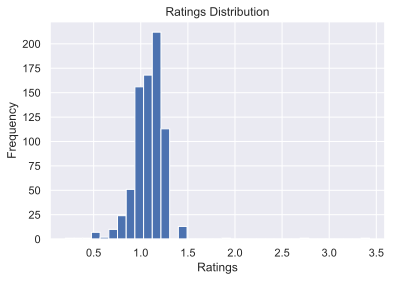

In [12]:
# plot the ratings histogram
plt.hist(tweets_and_dogs_df['rating'], bins=35)
plt.title('Ratings Distribution')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

# save the image
#plt.savefig('images/1_ratings_histograms.png')

plt.show;

The ratings distribution looks left skewed.The average rating is about 1.1 and they range from a minimum 0.2 to a maximum of about 3.4. We can see that there are a few extreme cute dogs in this dataset with values over 2.

e:\miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


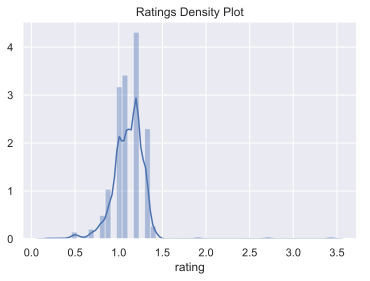

In [13]:
# density plot
fig1 = sns.distplot(tweets_and_dogs_df.rating).set_title('Ratings Density Plot').get_figure();

# save the image
#fig1.savefig('images/2_ratings_density.png')

In this density plot we can better see the shape of our ratings distribution. We can still se that peak at around 1.1 - 1.2 and how it rapidly decreases.

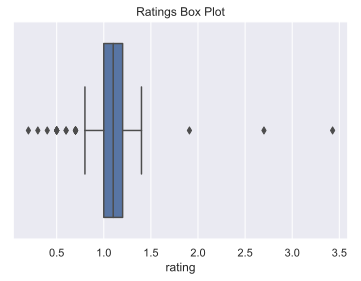

In [14]:
# tweet_favorite_count boxplot
fig2 = sns.boxplot(x='rating', data=tweets_and_dogs_df, orient="h").set_title('Ratings Box Plot').get_figure();

# save the image
#fig2.savefig('images/3_ratings_boxplot.png')

In this Ratings Box Plot we can see the extreme low ratings are more common than extreme high ratings.

#### Retweet Count Distribution

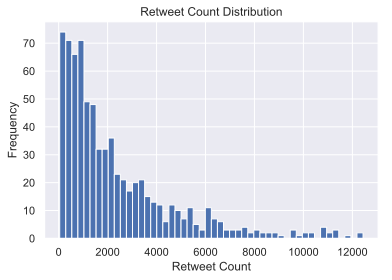

In [15]:
# plot the ratings histogram

plt.hist(tweets_and_dogs_df.query("retweet_count < 12500")['retweet_count'], bins=50)
plt.title('Retweet Count Distribution')
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')

# save the image
#plt.savefig('images/4_retweet_count_histograms.png')

plt.show;

The Retweet Count Distribution is right skewed with an average retweet count of about 2816. Data is ranging from a minimum of 44 to a maximum of 83277 retweets. The bulk of our data is less than 3000 retweet counts.

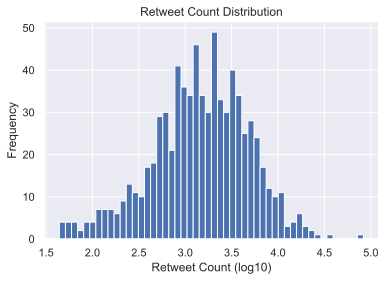

In [16]:
# plot the ratings histogram

plt.hist(tweets_and_dogs_df['retweet_count'].apply(np.log10), bins=50)
plt.title('Retweet Count Distribution')
plt.xlabel('Retweet Count (log10)')
plt.ylabel('Frequency')

# save the image
#plt.savefig('images/5_retweet_count_log10_histograms.png')

plt.show;

On a log10 scale the Retweet Count Distribution looks more normal.

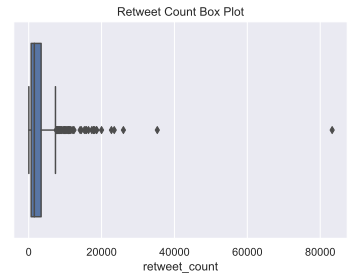

In [17]:
# tweet_favorite_count boxplot
fig3 = sns.boxplot(x='retweet_count', data=tweets_and_dogs_df, orient="h").set_title('Retweet Count Box Plot').get_figure();

# save the image
#fig3.savefig('images/6_retweet_count_boxplot.png')

In this box plot we can see how the extreme retweet counts values.

In [18]:
# descriptive statistics numbers for retweet count
tweets_and_dogs_df.retweet_count.describe()

count      762.000000
mean      2824.917323
std       4567.075970
min         44.000000
25%        689.500000
50%       1546.000000
75%       3411.250000
max      83277.000000
Name: retweet_count, dtype: float64

#### Favorite Count Distribution

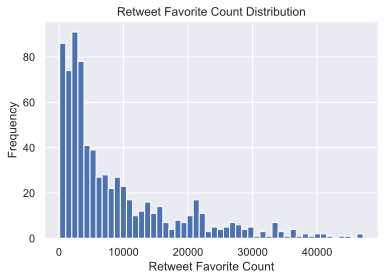

In [19]:
# plot the ratings histogram

plt.hist(tweets_and_dogs_df.query("tweet_favorite_count < 50000")['tweet_favorite_count'], bins=50)
plt.title('Retweet Favorite Count Distribution')
plt.xlabel('Retweet Favorite Count')
plt.ylabel('Frequency')

# save the image
#plt.savefig('images/7_retweet_favorite_histograms.png')

plt.show;

The Retweet Count Distribution is right skewed with an average favorite count of about 9778. Data is ranging from a minimum of 123 to a maximum of 163767 likes. 

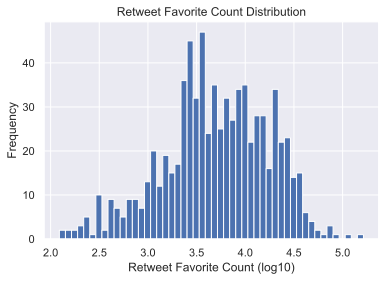

In [20]:
# plot the ratings histogram

plt.hist(tweets_and_dogs_df['tweet_favorite_count'].apply(np.log10), bins=50)
plt.title('Retweet Favorite Count Distribution')
plt.xlabel('Retweet Favorite Count (log10)')
plt.ylabel('Frequency')

# save the image
#plt.savefig('images/8_retweet_favorite_log10_histograms.png')

plt.show;

If we apply a log10 scale we can see that the likes data looks more normally distributed.

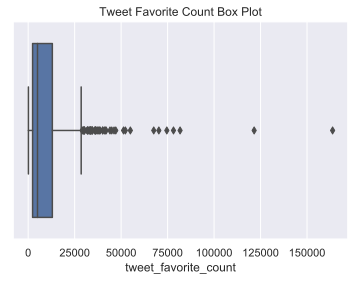

In [21]:
# tweet_favorite_count boxplot
fig4 = sns.boxplot(x='tweet_favorite_count', data=tweets_and_dogs_df, orient="h").set_title('Tweet Favorite Count Box Plot').get_figure();

# save the image
#fig4.savefig('images/6_retweet_favorite_boxplot.png')

Looking at this boxplot we can better get a sense of the outliers. We can see that favorite counts higher than 25000 is quite rare.

In [22]:
# descriptive statistics numbers for retweet count
tweets_and_dogs_df.tweet_favorite_count.describe()

count       762.000000
mean       9789.797900
std       13067.323504
min         123.000000
25%        2378.000000
50%        5018.000000
75%       13002.500000
max      163767.000000
Name: tweet_favorite_count, dtype: float64

#### Scatter Plots Matrix

Let's see the whole picture of our quantitative variables and take a look at their histograms and at their pairwise relationship plots.

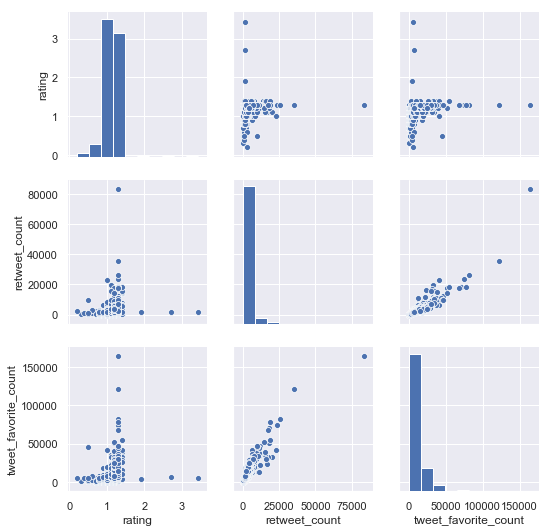

In [23]:
# `pairplot()` may become very slow with the SVG format
%config InlineBackend.figure_format = 'png' 
fig5 = sns.pairplot(tweets_and_dogs_df[['rating', 'retweet_count', 'tweet_favorite_count']]);

# save the image
#fig5.savefig('images/9_pairplot.png')

From the above scatter matrix we can see there isn't a linear relationship between rating and retweet count or retweet favorite count.

#### Ratings, retweets and likes

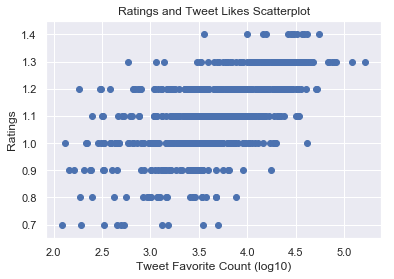

In [24]:
plt.scatter(tweets_and_dogs_df.query("rating > 0.6 and rating < 1.5")['tweet_favorite_count'].apply(np.log10), tweets_and_dogs_df.query("rating > 0.6 and rating < 1.5")['rating']);
plt.title('Ratings and Tweet Likes Scatterplot')
plt.xlabel('Tweet Favorite Count (log10)')
plt.ylabel('Ratings')

# save the image
#plt.savefig('images/10_ratings_likes_log10.png')

plt.show;

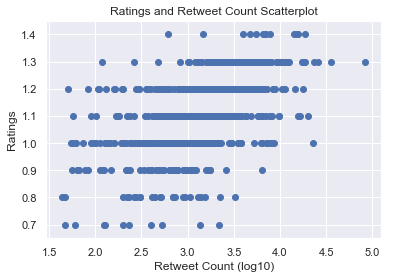

In [25]:
plt.scatter(tweets_and_dogs_df.query("rating > 0.6 and rating < 1.5")['retweet_count'].apply(np.log10), tweets_and_dogs_df.query("rating > 0.6 and rating < 1.5")['rating']);
plt.title('Ratings and Retweet Count Scatterplot')
plt.xlabel('Retweet Count (log10)')
plt.ylabel('Ratings')

# save the image
#plt.savefig('images/11_ratings_favorite_log10.png')

plt.show;

If we apply a log10 scale to our like counts and take into consideration our extreme ratings values and filter our dataset we can see that a more linear relationship than before between likes, retweet counts and ratings.

#### Retweet Count and Retweet Favorite Count Scatterplot

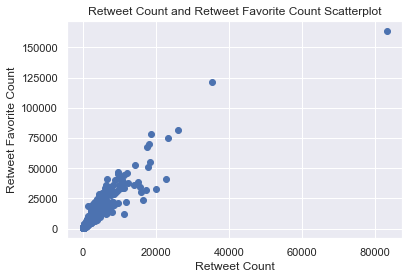

In [26]:
plt.scatter(tweets_and_dogs_df['retweet_count'], tweets_and_dogs_df['tweet_favorite_count']);
plt.title('Retweet Count and Retweet Favorite Count Scatterplot')
plt.xlabel('Retweet Count')
plt.ylabel('Retweet Favorite Count')

plt.show;

From the above scatterplot we can see that there is a strong linear correlation between retweet count and retweet favorite. A tweet with higher retweets count tend to have more likes.

In [27]:
tweets_and_dogs_df['retweet_count'].corr(tweets_and_dogs_df['tweet_favorite_count'])

0.9159435701774855

#### Mean probabilities per breed

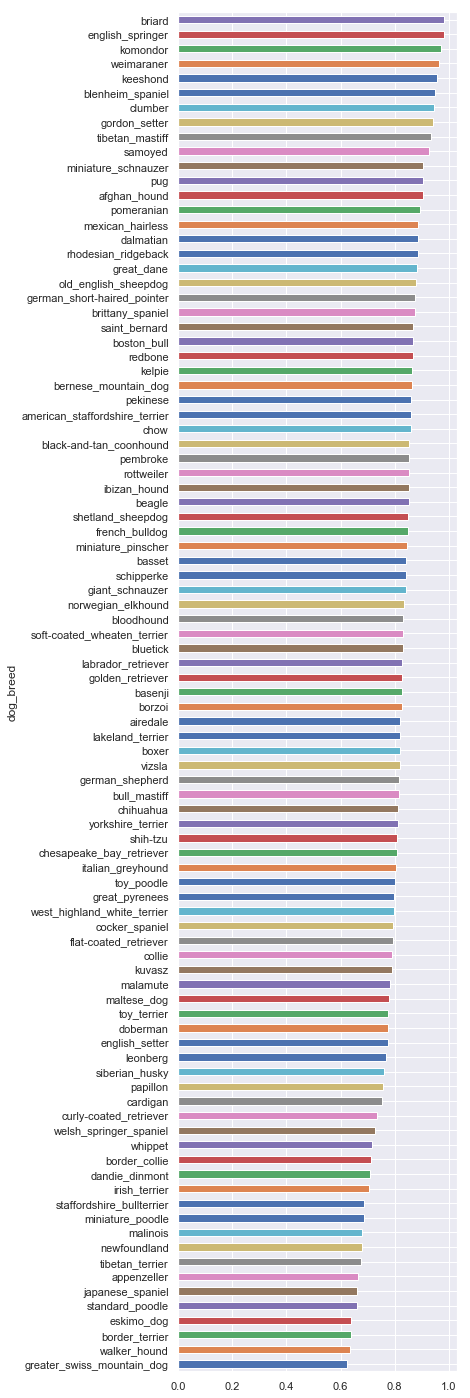

In [50]:
# mean probabilities per breed
tweets_and_dogs_df.groupby(['dog_breed'])['probability'].mean().sort_values().plot(kind='barh', figsize=(5,25));

Briard, English Springer and Komondor are top three dog breeds. 

##### Tweets per hour of the day

Let's see the busiest hour of the day for WeRateDogs tweets in our dataset.

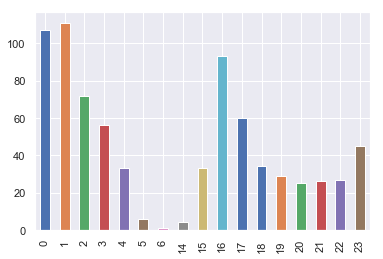

In [29]:
tweets_and_dogs_df.hour.value_counts().sort_index().plot(kind='bar');

1 am seem to be the busiest hour.

##### Tweets per month

Let's see the busiest month of the year for WeRateDogs tweets in our dataset.

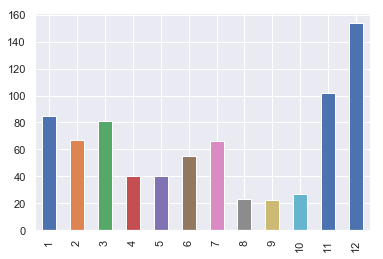

In [30]:
# tweets per month
fig6 = tweets_and_dogs_df.month.value_counts().sort_index().plot(kind='bar');

# save the image
#fig6.figure.savefig('images/12_busiest_month.png')

December is the month with the biggest number of tweets and September has the lowest number of tweets.

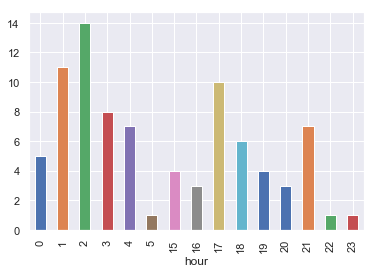

In [31]:
fig7 = tweets_and_dogs_df.query('month == 1').groupby(['hour']).tweet_id.count().plot(kind='bar');

# save the image
fig7.figure.savefig('images/13_busiest_hour.png')

So, for December, the busiest month of the year for WeRateDogs tweets, the busiest hour of the day is 2 am and 1 am is the second busiest hour of the day.

#### Let's see top three dog names.

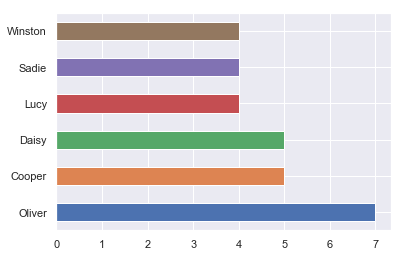

In [32]:
tweets_and_dogs_df.query('name != "None"').name.value_counts()[:6].plot(kind='barh');

We can see that Oliver is most popular followed by Cooper.

#### Top Dog Breeds by Ratings

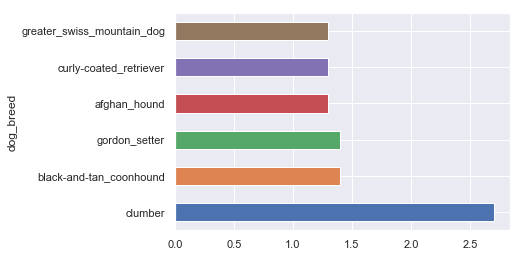

In [33]:
tweets_and_dogs_df.groupby('dog_breed')['rating'].mean().sort_values(ascending=False).iloc[:6].plot(kind="barh");

So, being a clumber dogs have highest ratings

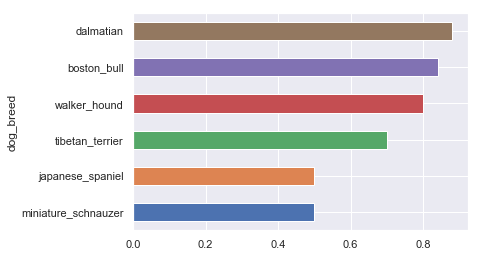

In [34]:
tweets_and_dogs_df.groupby('dog_breed')['rating'].mean().sort_values(ascending=True).iloc[:6].plot(kind="barh");

While miniature schnauzer and japanese spaniel have lowest ratings.

#### Mean rating by dog stages

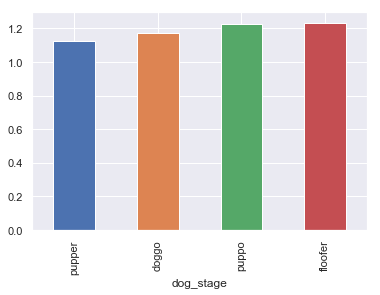

In [35]:
tweets_and_dogs_df.query('dog_stage != "None"').groupby('dog_stage').rating.mean().sort_values().plot(kind='bar');

So, on average, floofers receive higher ratings.

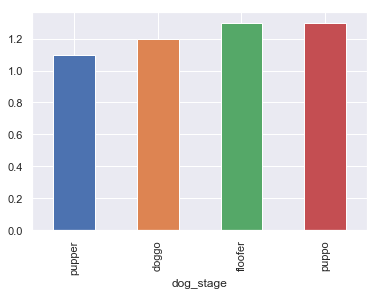

In [36]:
tweets_and_dogs_df.query('dog_stage != "None"').groupby('dog_stage').rating.median().sort_values().plot(kind='bar');

If we look at the median values, both a floofer and a puppo gives as equal chances in receiving a higher rating.

#### Let's see the dog with the highest rating.

In [37]:
import IPython

In [38]:
# get the image url, text an link to the tweet
jpg_url = tweets_and_dogs_df.query('dog_breed == "clumber"').jpg_url.values[0]
text = tweets_and_dogs_df.query('dog_breed == "clumber"').text.values[0]
url = tweets_and_dogs_df.query('dog_breed == "clumber"').url.values[0]

In [39]:
# display info and link to the original tweet
IPython.display.HTML('<a href=' + url + '><img src=' + jpg_url + ' width=250"><figcaption style="width:250px">' 
                     + text + '</figcaption></a>')

Well, this is a cute dog.

#### And lowest ratings

In [40]:
jpg_urls = tweets_and_dogs_df.query('dog_breed == "miniature_schnauzer" or dog_breed == "japanese_spaniel"').jpg_url.values
texts =  tweets_and_dogs_df.query('dog_breed == "miniature_schnauzer" or dog_breed == "japanese_spaniel"').text.values
urls = tweets_and_dogs_df.query('dog_breed == "miniature_schnauzer" or dog_breed == "japanese_spaniel"').url.values

In [41]:
len(jpg_urls)

2

In [42]:
import time
for i in range(len(jpg_urls)):
    display(IPython.display.HTML('<a href=' + urls[i] + '><img src=' + jpg_urls[i] + ' width=250"><figcaption style="width:250px">' 
                     + texts[i] + '</figcaption></a>'))

I'm not saying anything about these pictures, I don't want to be judgemental.